## Simpsons Machine Learning Challenge

Transfer learning and fine tuning a neural network for image recognition of 20 Simpsons characters to >99% validation accuracy verified by the CodaLab platform.

Team members:

- Josh Anthony (@joshanthony)
- Roger Middenway (@RMiddenway)
- Melissa Mony (@MelMony)

## 1. Setup

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
from tensorflow.python.keras.saving import hdf5_format
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import h5py, itertools, collections, time
# Keras neural network layers and optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Keras training callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Pre-trained models
from tensorflow.keras.applications import efficientnet
# Model importing
from tensorflow.keras.models import load_model
##################
# Verifications:
#################
print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
print("Tensorflow version: " + tf.__version__)

GPU is NOT used.
Tensorflow version: 2.4.1


In [13]:
# Hyperparameters
image_size = (224, 224)
input_shape = (224, 224, 3)
batch_size= 32

In [14]:
'''
    Split train and validation.
'''

# Create an image generator with a fraction of images reserved for validation: (TODO: try diff transform parameters)
image_generator = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.25,
    height_shift_range=0.25, 
#    brightness_range=0.1, 
    horizontal_flip=True,
    validation_split=0.1
    )

# Now, we create a training data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 224x224 pixels format.
train_ds =  DirectoryIterator(
    "dataset/simpsons_train/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'training',
)

# Similarly, we create a validation data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 224x224 pixels format.
val_ds = DirectoryIterator(
    "dataset/simpsons_train/",
    image_generator,
    class_mode='categorical',
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'validation',
    shuffle=False
)

# We save the list of classes (labels).
class_names = list(train_ds.class_indices.keys())
print(train_ds.samples)
# We also save the number of labels.
num_classes = train_ds.num_classes


Found 16503 images belonging to 20 classes.
Found 1824 images belonging to 20 classes.
16503


In [15]:
# Import base pre-trained model
enb4 = efficientnet.EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

In [16]:
# Optimizer
learn_rate = 1e-4
adam=Adam(lr=learn_rate) 

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=5, min_lr=1e-9, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=100)
checkpoint = ModelCheckpoint('model-{epoch:02d}-{val_accuracy:.2f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks = [checkpoint, reduce_lr, early_stopping]

## 2. Transfer Learning

In [12]:
def build_model():
    base_model = enb4
    
    # Hyperparameters
    trainable_layers_choice = 31
    dropout_choice = 0.05
    dense_input_choice = 512
    
    # Unfreeze layers
    for layer in base_model.layers[:trainable_layers_choice]:
        layer.trainable=False
    for layer in base_model.layers[trainable_layers_choice:]:
        layer.trainable=True
    
    model = Sequential()
    # Base model
    model.add(base_model)
    # Pooling
    model.add(GlobalAveragePooling2D(name="sc_pooling_avg"))
    # Dropout
    model.add(Dropout(dropout_choice, name="sc_dropout"))
    # Additional dense layer
    model.add(Dense(dense_input_choice, activation='relu', name="sc_relu_dense"))
    # Final dense layer
    model.add(Dense(num_classes, activation='softmax', name="sc_final_dense"))
    # Activation
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [13]:
def fit_model(model):
    return model.fit(x=train_ds, validation_data=val_ds, epochs=200, batch_size=batch_size, callbacks=callbacks, verbose=1)

In [1]:
model = build_model()
history = fit_model(model)

In [ ]:
# Save the model if required
with h5py.File('model.h5', mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['class_names'] = class_names
    f.attrs['image_size'] = image_size

## 3. Model fine tuning

In [23]:
tuned = load_model('model.h5')

In [24]:
def unfreeze_model(model):
    # We unfreeze all layers while leaving BatchNormalization layers frozen
    model.trainable = True
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

unfreeze_model(tuned)

In [7]:
history = fit_model(tuned)

## 4. Results analysis

In [31]:
# Load model if required
final_model = load_model('model.h5')

In [32]:
val_ds.reset()
val_ds.shuffle = False
val_ds.next()
y_prob = final_model.predict(val_ds)
y_pred = y_prob.argmax(axis=-1)
y_true = val_ds.labels
print(classification_report(y_true, y_pred, target_names=class_names))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.99      0.99        84
  apu_nahasapeemapetilon       1.00      1.00      1.00        57
            bart_simpson       0.99      0.97      0.98       127
charles_montgomery_burns       0.98      1.00      0.99       112
            chief_wiggum       0.99      0.99      0.99        88
          comic_book_guy       1.00      1.00      1.00        46
          edna_krabappel       1.00      0.98      0.99        41
           homer_simpson       0.99      0.98      0.99       215
           kent_brockman       1.00      0.98      0.99        43
        krusty_the_clown       0.99      1.00      1.00       111
           lenny_leonard       1.00      1.00      1.00        31
            lisa_simpson       0.98      0.98      0.98       128
           marge_simpson       0.98      0.98      0.98       122
            mayor_quimby       1.00      1.00      1.00        32
     milh

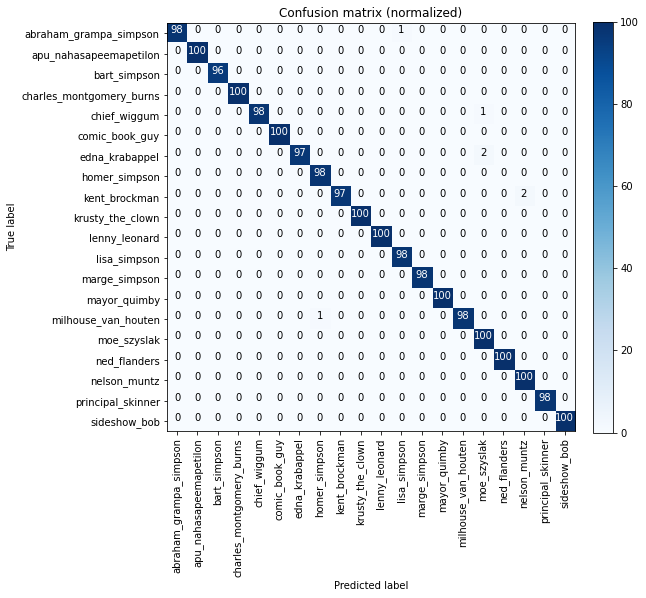

In [33]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    vmax = cm.max()
    if normalize:
        title = 'Confusion matrix (normalized)'
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = [[int(j*100) for j in i ] for i in cm]
        cm =np.array(cm)
        vmax = 100
        
    plt.figure(figsize=(8,8))

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=vmax)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar(im,fraction=0.046, pad=0.04)

cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm=cnf_matrix, classes=class_names, title='Confusion Matrix', normalize=True)